In [2]:
!pip install simplemma


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import re
import numpy as np
import nltk
import matplotlib.pyplot as plt
import simplemma
nltk.download('punkt_tab')

from kmeans_lloyd.kmeans import kmeans
from kmeans_lloyd.silhouette_score import silhouette_score_basic
from kmeans_lloyd.plot import plot_kmeans_results
from svd_power_iteration.svd import svd_full, matrix_multiplication

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
df = pd.read_csv('sbi_reviews.csv')

In [6]:
stopwords = set()
with open('stopwords.txt', 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():
            stopwords.add(line.strip())

In [8]:
def tokenizer(text, stop_words={}):

  tokenized_list=[]
  text=re.sub(r"""['’"`�]""", '', text)
  text=re.sub(r"""[\-.,:+*/_—!?«»()]""", ' ', text)

  for word in nltk.word_tokenize(text):
    word = word.lower()
    if re.search(r'\d', word):
      continue
    if word not in stop_words:
      word = simplemma.lemmatize(word, lang='en')
      if word not in stop_words:
        if word not in stop_words and len(word) >= 3:
            tokenized_list.append(word)

  return tokenized_list


In [9]:
tokanized_reviews = []

for _, row in df.iterrows():
    tokanized_reviews.append(tokenizer(row['review'], stopwords))

print(tokanized_reviews)


[['state', 'bank', 'india', 'locate', 'nearby', 'area', 'open', 'save', 'account', 'bank', 'customer', 'service', 'bank', 'statement', 'time', 'bank', 'agent', 'inform', 'detail', 'require', 'easy', 'convenience', 'money', 'deposit'], ['salary', 'account', 'sbi', 'apply', 'card', 'statement', 'time', 'satisfy', 'account', 'net', 'banking', 'function', 'smooth', 'convenient', 'offer', 'card'], ['savings', 'account', 'sbi', 'year', 'keep', 'balance', 'deduct', 'amount', 'keep', 'maintain', 'amount', 'transaction', 'emi', 'transfer', 'account', 'only', 'customer', 'service', 'okay'], ['mother', 'suggest', 'sbi', 'open', 'save', 'account', 'employee', 'know', 'benefit', 'detail', 'account', 'past', 'year', 'need', 'maintain', 'minimum', 'balance', 'atm', 'branch', 'near', 'detail', 'update', 'bank'], ['sbi', 'internet', 'banking', 'fast', 'easy', 'access', 'savings', 'account', 'year', 'withdrawal', 'cash', 'time', 'charge', 'taking', 'cash', 'atm', 'transcation', 'need', 'maintain', 'mini

In [10]:
from collections import Counter
unique_words = sorted(set(word for review in tokanized_reviews for word in review))

bow_matrix = np.zeros((len(tokanized_reviews), len(unique_words)), dtype=int)

for i, review in enumerate(tokanized_reviews):
    word_count = Counter(review)
    for j, word in enumerate(unique_words):
        bow_matrix[i, j] = word_count.get(word, 0)

print("Unique Words (Dictionary):", unique_words)
print("\nBag of Words Matrix:")
print(bow_matrix)

Unique Words (Dictionary): ['aadhar', 'able', 'access', 'accord', 'account', 'activate', 'active', 'activity', 'actually', 'add', 'additional', 'address', 'advantage', 'agent', 'ago', 'agree', 'alert', 'alone', 'amount', 'annual', 'answere', 'anyway', 'app', 'applicable', 'application', 'apply', 'approach', 'approval', 'approve', 'approximately', 'area', 'arrogant', 'ask', 'aske', 'assistance', 'assistsance', 'assitance', 'associate', 'atm', 'atms', 'attempt', 'attitude', 'attractive', 'authority', 'avail', 'availability', 'average', 'avoid', 'aware', 'away', 'awesome', 'back', 'bad', 'balance', 'bank', 'banker', 'banking', 'base', 'basis', 'beginning', 'behave', 'behavior', 'being', 'belong', 'benefit', 'bill', 'bite', 'block', 'bone', 'book', 'booking', 'branch', 'branchs', 'brand', 'call', 'campus', 'can', 'car', 'card', 'care', 'case', 'cash', 'cashless', 'cast', 'cdm', 'cdms', 'center', 'central', 'centre', 'change', 'charge', 'chargeable', 'check', 'cheque', 'child', 'choose', 'c

In [11]:
from scipy.linalg import svd
U, Sigma, Vt = svd(bow_matrix)

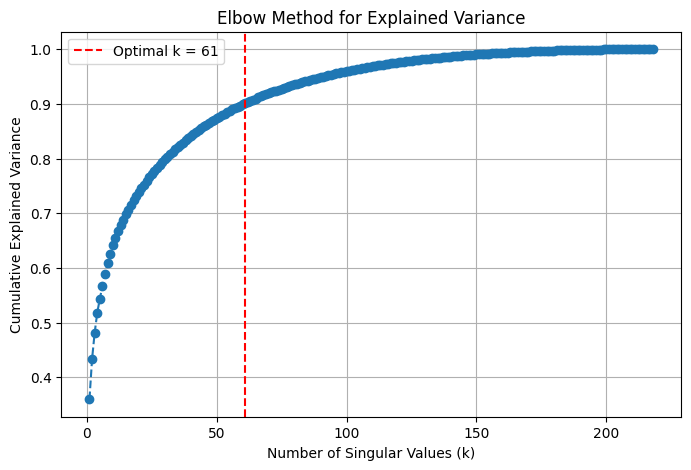

Optimal number of singular values (k) based on 90% explained variance: 61


In [13]:
explained_variance = np.cumsum(Sigma**2) / np.sum(Sigma**2)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(Sigma) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Elbow Method for Explained Variance')
plt.xlabel('Number of Singular Values (k)')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

threshold = 0.9
optimal_k = np.argmax(explained_variance >= threshold) + 1
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()

plt.show()

print(f"Optimal number of singular values (k) based on 90% explained variance: {optimal_k}")

In [14]:
k = optimal_k
U_k = U[:, :k]
Sigma_k = np.diag(Sigma[:k])
Vt_k = Vt[:k, :]

reduced_matrix = U_k @ np.diag(Sigma_k)

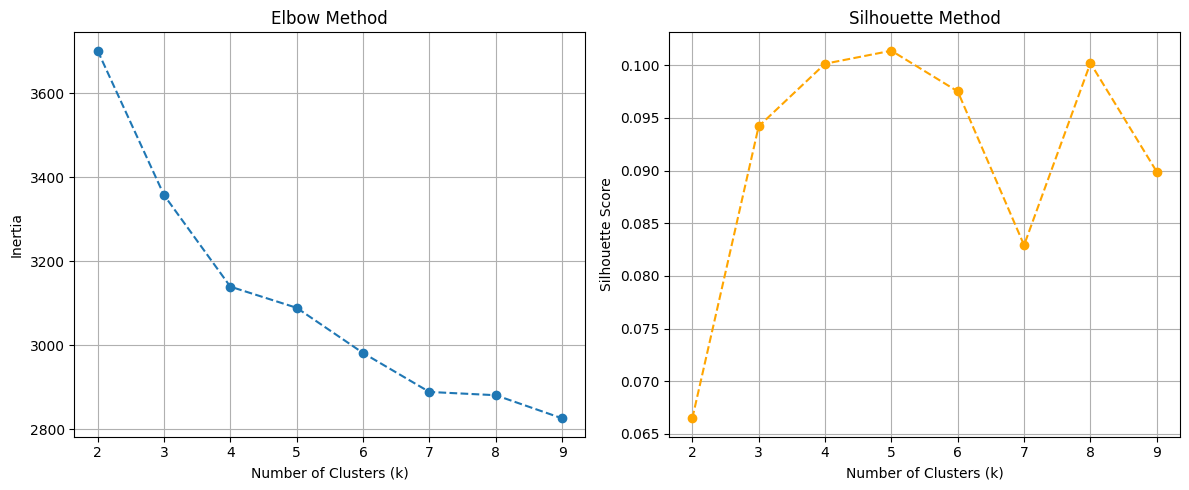

The optimal number of clusters based on the silhouette method is: 5


In [15]:
num_clusters = range(2, 10)

wcss = []
silhouette_scores = []

for k in num_clusters:
    centroids, final_labels, final_wcss, n_iter = kmeans(np.dot(U_k, Sigma_k), k=k)

    wcss.append(final_wcss)
    score = silhouette_score_basic(np.dot(U_k, Sigma_k), final_labels)
    silhouette_scores.append(score)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(num_clusters, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(num_clusters, silhouette_scores, marker='o', linestyle='--', color='orange')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

optimal_k = num_clusters[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters based on the silhouette method is: {optimal_k}")

Iterations performed: 11
Final Inertia (WCSS): 3027.9578


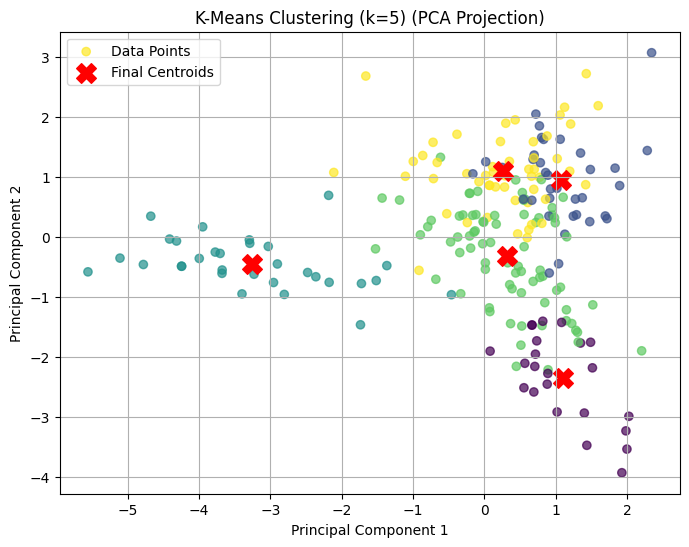

In [19]:
final_centroids, final_labels, final_inertia, iterations = kmeans(np.dot(U_k, Sigma_k), optimal_k, max_iters=300, tol=1e-5)
print(f"Iterations performed: {iterations}")
print(f"Final Inertia (WCSS): {final_inertia:.4f}")

plot_kmeans_results(np.dot(U_k, Sigma_k), final_labels, final_centroids)

In [20]:
centroid_word_importance = matrix_multiplication(final_centroids, Vt_k)

print("Shape of Centroid Word Importance Matrix:", centroid_word_importance.shape)

n_top_words = 10

print(f"\nTop {n_top_words} most important words for each cluster:")

for i in range(5):
    word_importance_for_centroid = centroid_word_importance[i, :]

    sorted_word_indices = np.argsort(np.abs(word_importance_for_centroid))[::-1]

    print(f"\nCluster {i+1}:")

    for j in range(n_top_words):
        word_index = sorted_word_indices[j]

        word = unique_words[word_index]

        importance_score = word_importance_for_centroid[word_index]

        print(f"  {word}: {importance_score:.4f}")


Shape of Centroid Word Importance Matrix: (5, 510)

Top 10 most important words for each cluster:

Cluster 1:
  bank: 1.9070
  account: 1.7874
  charge: 1.6109
  sbi: 1.0423
  transaction: 1.0323
  holding: 0.9633
  year: 0.9483
  balance: 0.9295
  message: 0.9280
  alert: 0.9211

Cluster 2:
  account: 3.3388
  bank: 1.1681
  balance: 0.9933
  year: 0.9332
  savings: 0.7405
  sbi: 0.7242
  open: 0.6662
  charge: 0.6546
  india: 0.6361
  salary: 0.6059

Cluster 3:
  service: 2.7423
  banking: 1.7117
  account: 1.1935
  transaction: 1.0046
  year: 0.9079
  past: 0.7762
  well: 0.7564
  customer: 0.7155
  net: 0.6696
  sbi: 0.6449

Cluster 4:
  account: 1.5654
  sbi: 1.0462
  maintain: 1.0150
  balance: 0.9887
  minimum: 0.9364
  year: 0.8103
  need: 0.7916
  charge: 0.7704
  service: 0.7394
  savings: 0.5397

Cluster 5:
  account: 1.7761
  branch: 1.4198
  sbi: 0.9278
  bank: 0.7749
  balance: 0.7743
  year: 0.7360
  banking: 0.6799
  facility: 0.6541
  response: 0.6081
  need: 0.5655


In [21]:
if 'cluster' not in df.columns:
    if len(df) == len(final_labels):
        df['cluster'] = final_labels
        print("Cluster labels added to the DataFrame.")
    else:
        print(f"Error: Length mismatch! DataFrame has {len(df)} rows, but kmeans.labels_ has {len(final_labels)} entries.")

if 'cluster' in df.columns:
    n_samples_per_cluster = 5
    print(f"\nSampling {n_samples_per_cluster} random reviews from each cluster:")

    for i in range(5):
        print(f"\n--- Cluster {i+1} Samples ---")

        cluster_df = df[df['cluster'] == i]

        num_to_sample = min(n_samples_per_cluster, len(cluster_df))

        if num_to_sample > 0:
            sampled_reviews = cluster_df['review'].sample(n=num_to_sample)

            for idx, review in enumerate(sampled_reviews):
                print(f" Sample {idx+1}: {review}")
        else:
            print(" (No reviews in this cluster to sample)")

Cluster labels added to the DataFrame.

Sampling 5 random reviews from each cluster:

--- Cluster 1 Samples ---
 Sample 1: I am holding saving account with SBI for more than 10 years. Need to maintain a minimum balance account. Some time hidden charges are avail and deduct some amount. ATM and branches are near. Net banking is user friendly to access. ATM charges are avail in this bank.
 Sample 2: I am holding a salary come saving account  from SBI for more than 12 years. There is no hidden charges in this bank. But need to maintain a minimum balance of 1000 rupees. I am using mobile app and it is user friendly to access. I use to get an alert messages from bank whenever I do a transactions. ATM charges are avail of 22 rupees if I use  more than 5 times with same bank and  other banks more than 3 times in a month.
 Sample 3: I am holding a saving account with SBI for more than 2 years. Need to maintain a minimum balance of 5K. There is some  hidden charges which is high when compare to